In [101]:
import cv2
import numpy as np
import IPython
import math

def show(img):
    # Save the image to a temporary byte buffer
    is_success, buffer = cv2.imencode(".png", img)
    
    if is_success:
        # Display the image using IPython's display function
        IPython.display.display(IPython.display.Image(data=buffer.tobytes()))
    else:
        print("Error encoding image for display.")

def pixels_to_angle(pixels): # outputs in degrees
    theta =  ( 2 * math.atan(4.25/11) ) * ( pixels / 671.0410824679549 )
    return theta

def angle_to_pixels(theta): # outputs in degrees
    pixels = ( theta * 671.0410824679549 ) / ( 2 * math.atan(4.25/11) )
    return pixels

def distance_to_pixels(distance): #input distance in milimeters
    r_d = 69 # 69 mm
    theta = 2 * math.asin( r_d / distance )   
    pixels = angle_to_pixels(theta)
    return pixels

def pixels_to_distance(pixels):
  theta = pixels * ( 2 * math.atan(4.25/11) ) / ( 671.0410824679549 )
  r_d = 69 # 69 mm
  d_c = r_d / math.sin( theta / 2 )
  return d_c

def extract_ball_position(img1,img2):
    # Calculate the absolute difference
    diff12 = cv2.absdiff(img1, img2)
    
    
    # Dilate the image
    size=15
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    image = cv2.dilate(diff12, kernel_dilate, iterations=1)
    
    # Apply Threshold to the image
    ret, image = cv2.threshold(image, 64, 255, cv2.THRESH_BINARY)
    image = cv2.erode(image, kernel_dilate, iterations=1)
    
    # Find contours
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(grey_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)<1:
        return None
    
    # Isolate contour with the greatest moment
    greatest_counter, greatest_moment = sorted( 
        [ [ contour, cv2.moments(contour) ] for contour in contours ],
        key=lambda x: x[1]['m00']
    )[-1]
    
    # find center of mass
    pixel_area = greatest_moment['m00']
    if pixel_area==0:
        return None

    alpha_x_pixels = greatest_moment['m10']/pixel_area - 1920/2
    alpha_y_pixels = 1080/2 - greatest_moment['m01']/pixel_area
    alpha_x = pixels_to_angle(alpha_x_pixels)/math.pi*180
    alpha_y = pixels_to_angle(alpha_y_pixels)/math.pi*180
    
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(greatest_counter)
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000

    return {
        "alpha":(alpha_x,alpha_y), # degrees ( right, up )
        'distance':distance # meters
    }

In [777]:
def extract_pink_ball_position(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #show(hsv)
    
    lower_green = np.array([int(255*0.0), int(255*0.3), int(255*0.6)])
    upper_green = np.array([int(255*0.03), int(255*0.5), int(255*0.9)])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    #show(mask)
    
    # Dilate the image
    size=5
    iterations = 2
    
    image=mask.copy()
    
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    image = cv2.erode(image, kernel_dilate, iterations=iterations)
    
    image = cv2.dilate(image, kernel_dilate, iterations=iterations)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    
    # Find contours
    # grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)<1:
        return None
    
    # Isolate contour with the greatest moment
    greatest_counter, greatest_moment = sorted( 
        [ [ contour, cv2.moments(contour) ] for contour in contours ],
        key=lambda x: x[1]['m00']
    )[-1]
    
    # markup = img1.copy()
    # markup = cv2.drawContours(markup, [greatest_counter], -1, (0, 255, 0), -1)
    # show(markup)
    
    
    # find center of mass
    pixel_area = greatest_moment['m00']
    alpha_x_pixels = greatest_moment['m10']/pixel_area - 1920/2
    alpha_y_pixels = 1080/2 - greatest_moment['m01']/pixel_area
    alpha_x = pixels_to_angle(alpha_x_pixels)/math.pi*180
    alpha_y = pixels_to_angle(alpha_y_pixels)/math.pi*180
    
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(greatest_counter)
    
    # markup = img.copy()
    # markup = cv2.drawContours(markup,points,-1,(255,00,255),10)
    # show(markup)
    
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000
    
    return {
        "alpha":(alpha_x,alpha_y), # degrees ( right, up )
        'distance':distance # meters
    }

In [ ]:
flag=True

while flag:
    ret, frame = cap.read()
    frames.append(frame)

    out = extract_pink_ball_position(frames[-1])
    
    if out==None:
        continue

    out.update({'frame':int(cap.get(cv2.CAP_PROP_POS_FRAMES))})
    
    
    alpha_x,alpha_y=out['alpha']
    d_c = out['distance']*1000
    radius = int( distance_to_pixels( d_c ) / 2 )
    x = int( 1920/2 + angle_to_pixels(alpha_x/180*math.pi) )
    y = int( 1080/2 - angle_to_pixels(alpha_y/180*math.pi) )
    
    out.update({
        'radius':radius,
        'center':(x,y)
    })
    
    data.append(out)
    
    
    # markup = frames[-2].copy()
    # markup = cv2.circle(markup, (x,y), radius, (255,0,0), 3)
    # show(markup)
    
    markup = frames[-1].copy()
    markup = cv2.circle(markup, (x,y), radius, (255,0,0), 3)
    IPython.display.clear_output(wait=True)
    show(markup)
    print(out)
    print(f"({x:.2f},{y:.2f}), {diameter:.2f}")
    

### 04 - Determining Ball Position from two Frames - revisited

In [9]:
# 04 - Determining Ball Position from two Frames revisited

import cv2
import numpy as np
import IPython
import math

def show(img):
    # Save the image to a temporary byte buffer
    is_success, buffer = cv2.imencode(".png", img)
    
    if is_success:
        # Display the image using IPython's display function
        IPython.display.display(IPython.display.Image(data=buffer.tobytes()))
    else:
        print("Error encoding image for display.")

def pixels_to_angle(pixels): # outputs in degrees
    theta =  ( 2 * math.atan(4.25/11) ) * ( pixels / 671.0410824679549 )
    return theta

def pixels_to_distance(pixels):
  theta = pixels * ( 2 * math.atan(4.25/11) ) / ( 671.0410824679549 )
  r_d = 69 # 69 mm
  d_c = r_d / math.sin( theta / 2 )
  return d_c

framepaths=[f"G:\\My Drive\\School\\2025 _Spring\\EE 497\\Frame-by-frame demo 01\\0{i}.png" for i in range(1,4) ]

# https://stackoverflow.com/questions/56183201/detect-and-visualize-differences-between-two-images-with-opencv-python

def angle_to_pixels(theta): # outputs in degrees
    pixels =  (671.0410824679549) * theta / ( 2 * math.atan(4.25/11) )
    return pixels

def distance_to_pixels(d_c):
    r_d = 69 # 69 mm
    theta = 2 * math.asin( r_d / d_c )
    pixels = angle_to_pixels(theta)
    return pixels


# Load two images for difference calculation
img1 = cv2.imread( framepaths[1] )
img2 = cv2.imread( framepaths[2] )

def extract_ball_position(img1,img2):
    # Calculate the absolute difference
    diff12 = cv2.absdiff(img1, img2)
    
    # Dilate the image
    size=15
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    image = cv2.dilate(diff12, kernel_dilate, iterations=1)
    
    # Apply Threshold to the image
    ret, image = cv2.threshold(image, 64, 255, cv2.THRESH_BINARY)
    image = cv2.erode(image, kernel_dilate, iterations=1)
    
    # Find contours
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(grey_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Isolate two contours with the greatest moment
    temp = sorted( 
        [ [ contour, cv2.moments(contour) ] for contour in contours ],
        key=lambda x: x[1]['m00']
    )[-2:]
    greatest_counters = [ item[0] for item in temp ]
    greatest_moments = [ item[1] for item in temp ]
    
    #combined contours into one "contour"
    combined_contour = np.array([list(greatest_counters[0]) + list(greatest_counters[1])])

    # Draw all contours on the original image
    
    # image=img1.copy()
    # cv2.drawContours(image, combined_contour, -1, (0, 255, 0), -1)
    # show(image)
    
    # find center of mass
    pixel_areas = [ item['m00'] for item in greatest_moments ] 
    alpha_x_pixels = [ item['m10']/item['m00'] - 1920/2 for item in greatest_moments ]
    alpha_y_pixels = [ 1080/2 - item['m01']/item['m00'] for item in greatest_moments ]
    
    weighted_centers = list( zip(pixel_areas,zip(alpha_x_pixels,alpha_y_pixels)) )
    # [(4187.5, (-346.0060815615881, 293.6062924544496)),
    #  (6796.5, (89.744966772113, 220.3337992594228))]
    total_mass = sum( [ x[0] for x in weighted_centers] )
    weighted_avg_center = sum( [ x[0]*np.array(x[1]) for x in weighted_centers ] ) / total_mass

    # alpha_x, alpha_y are angles in degrees up/right from center/forward
    alpha_x = pixels_to_angle(weighted_avg_center[0])/math.pi*180
    alpha_y = pixels_to_angle(weighted_avg_center[1])/math.pi*180   
    
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(combined_contour[0])
    # print(obj)
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000
   
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(combined_contour[0])
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000
    print(f"Distance: {distance:.2f} m ")
    
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    # markup = img1.copy()
    # markup = cv2.drawContours(markup,points,-1,(255,00,255),10)
    # show(markup)
    
    x = int( 1920/2 + angle_to_pixels( alpha_x/180 * math.pi ) )
    y = int( 1080 / 2 - angle_to_pixels( alpha_y/180 * math.pi ) )
    radius = int( distance_to_pixels(distance*1000) / 2 )
    # print( x, y, radius )
    
    # markup = img1.copy()
    # markup = cv2.addWeighted(img1,0.5,img2,0.5,0)
    # alpha_x, alpha_y, distance
    # markup = cv2.circle(markup, (x,y), radius, (255,0,0), 3)
    # show(markup)

    return {
        'distance':distance,
        'alpha':(alpha_x, alpha_y)
    }

In [11]:
vid_path=r"G:\My Drive\School\2025 _Spring\EE 497\VID_20250505_232051624.mp4"

https://docs.opencv.org/4.x/

In [33]:
try:
    cap.release()
except:
    pass
cap = cv2.VideoCapture( filename = vid_path )

In [16]:
timestamp_ms = 1000 # First ball is thrown around 1s
success_set = cap.set(cv2.CAP_PROP_POS_MSEC, timestamp_ms)


In [18]:
frames=[]

In [20]:
data=[]

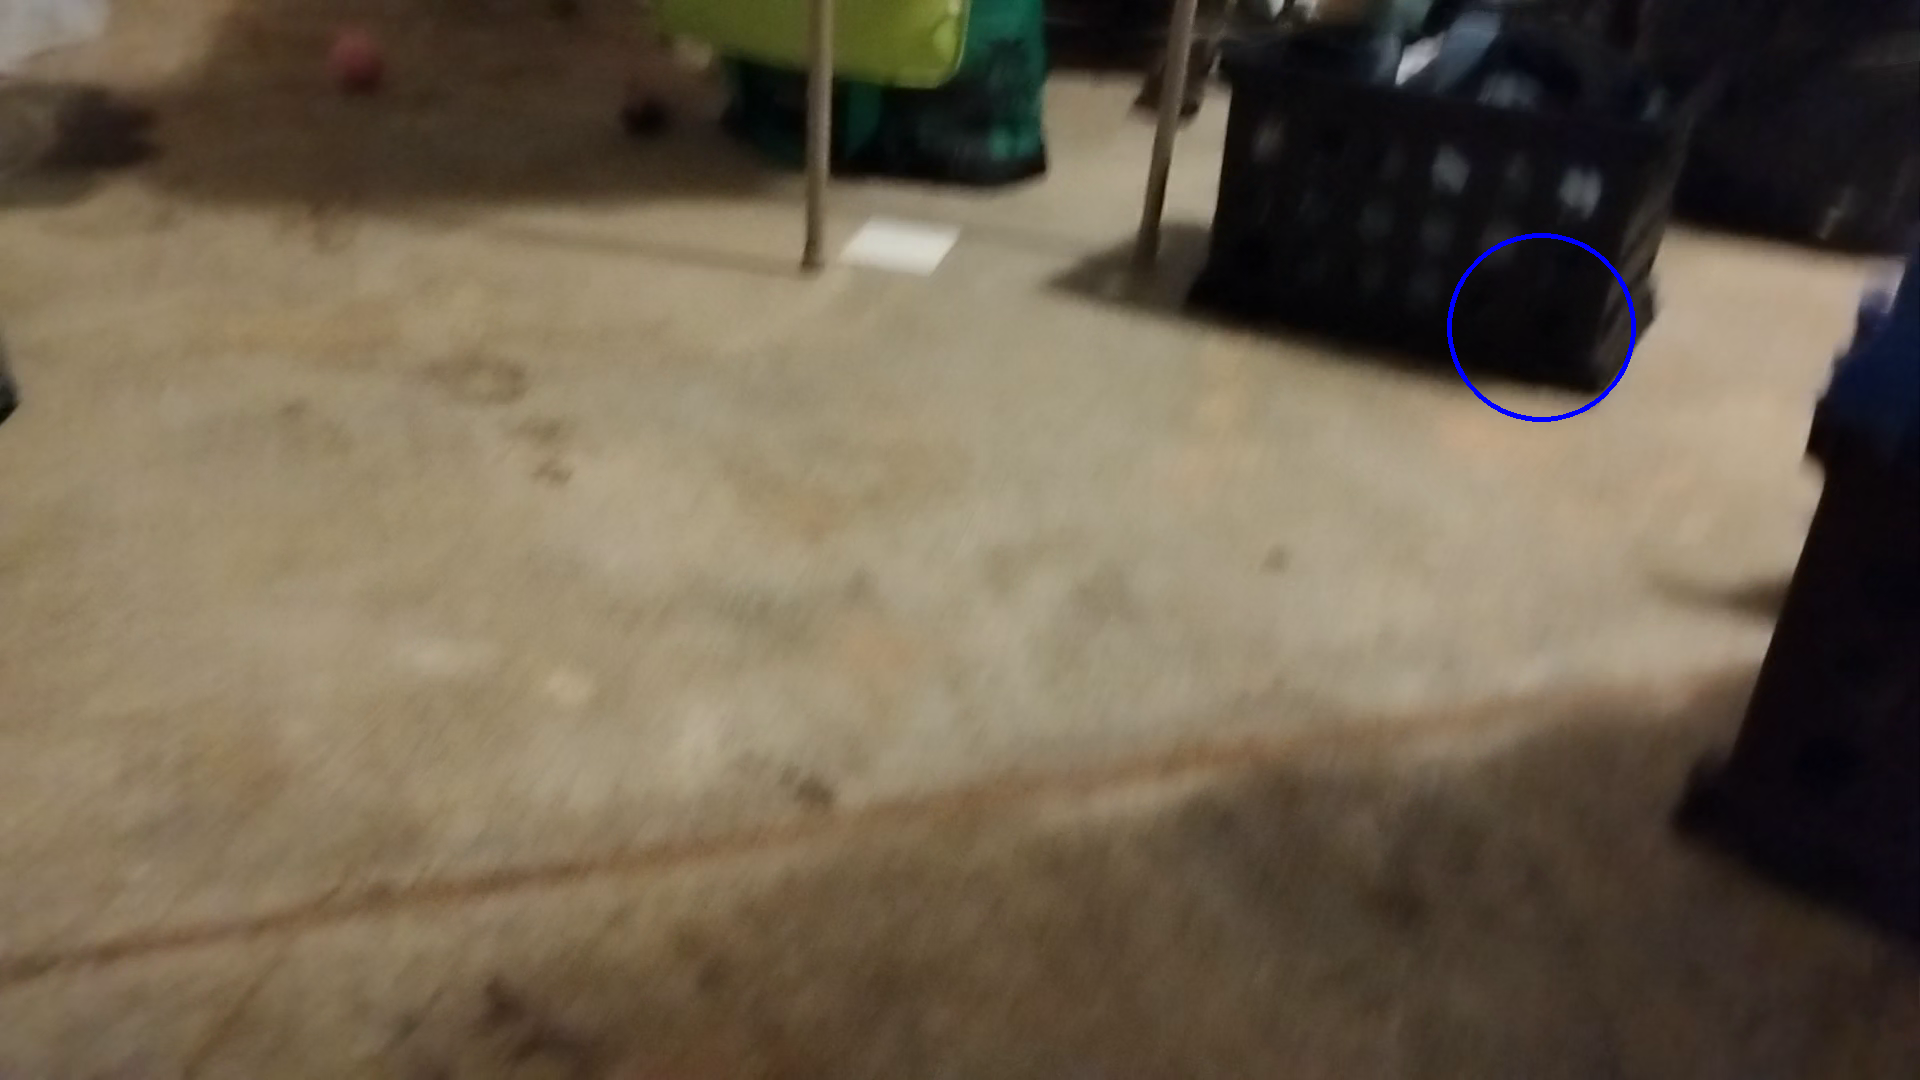

{'distance': 0.6777299830238501, 'alpha': (np.float64(36.59098083570769), np.float64(13.375623333366455)), 'frame': 683, 'radius': 92, 'center': (1541, 327)}
(1541.00,327.00), 92.00


KeyboardInterrupt: 

In [47]:
flag=True

while flag:
    ret, frame = cap.read()
    frames.append(frame)
    if len(frames)<2:
        continue
    try:
        out = extract_ball_position(frames[-2],frames[-1])
    except:
        continue
    if out==None:
        continue

    out.update({'frame':int(cap.get(cv2.CAP_PROP_POS_FRAMES))})
    
    
    alpha_x,alpha_y=out['alpha']
    d_c = out['distance']*1000
    radius = int( distance_to_pixels( d_c ) / 2 )
    x = int( 1920/2 + angle_to_pixels(alpha_x/180*math.pi) )
    y = int( 1080/2 - angle_to_pixels(alpha_y/180*math.pi) )
    
    out.update({
        'radius':radius,
        'center':(x,y)
    })
    
    data.append(out)
    
    
    # markup = frames[-2].copy()
    # markup = cv2.circle(markup, (x,y), radius, (255,0,0), 3)
    # show(markup)
    
    markup = frames[-1].copy()
    markup = cv2.circle(markup, (x,y), radius, (255,0,0), 3)
    video_out.write(markup)
    IPython.display.clear_output(wait=True)
    show(markup)
    print(out)
    print(f"({x:.2f},{y:.2f}), {radius:.2f}")
    

In [51]:
video_out.release()

In [53]:
cap.release()

In [35]:
out_frames=[]

In [37]:
import time

In [41]:
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_ms = (total_frames / fps) * 1000 if fps > 0 else 0

print(f"Video FPS: {fps:.2f}")
print(f"Total Frames: {total_frames}")
print(f"Video Duration: {duration_ms / 1000:.2f} seconds")

Video FPS: 29.04
Total Frames: 683
Video Duration: 23.52 seconds


In [45]:
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# Define the fps to be equal to 10. Also frame size is passed.

video_out = cv2.VideoWriter('outpy.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (1920,1080))


In [791]:
current_frame=0
index=0
end=683

while current_frame<end:
    markup = frames[0].copy()
    if datum['frame']>current_frame:
        index+=1
    datum=data[index]
    markup = cv2.circle(markup, datum['center'], datum['radius'], (255,0,0), -1)
    out.write(markup)
    current_frame+=1

IndexError: list index out of range

In [793]:
out.release()

In [743]:
for datum in data[2:]:
    markup = frames[0].copy()
    markup = cv2.circle(markup, datum['center'], datum['radius'], (255,0,0), -1)
    IPython.display.clear_output(wait=True)
    out_frames.append(markup)

In [71]:
actual_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
actual_frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)

print(actual_timestamp_ms)
print(actual_frame_number)

In [795]:
cap.release()

In [3]:
# example code
raise NameError("Don't run this block")
# Open the video file
cap = cv2.VideoCapture( vid_path ) # cv2.VideoCapture( filename[, apiPreference] )
 
# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Video file opened successfully!")
 
# Read the first frame to confirm reading
ret, frame = cap.read()
# bool ret; // was a frame successfully read?
# numpy.array  frame // The image frame extracted

 
if ret:
 
    # Display the frame using imshow
    cv2.imshow("First Frame", frame)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()  # Close the window
else:
    print("Error: Could not read the frame.")
 
# Release the video capture object
cap.release()

NameError: Don't run this block

1732.111111111111
49.0


In [1]:
# Gemini 2.5 Pro Preview 03-25
raise NameError("Don't run the below code")
# "python opencv VideoCapture seek timestamp"

import cv2
import os

def seek_to_timestamp(video_path, timestamp_ms):
    """
    Opens a video, seeks to a specific timestamp, and displays the frame.

    Args:
        video_path (str): Path to the video file.
        timestamp_ms (float): Timestamp to seek to, in milliseconds.
    """
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    # Get video properties (optional, but good for context)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_ms = (total_frames / fps) * 1000 if fps > 0 else 0
    
    print(f"Video FPS: {fps:.2f}")
    print(f"Total Frames: {total_frames}")
    print(f"Video Duration: {duration_ms / 1000:.2f} seconds")

    if timestamp_ms > duration_ms and duration_ms > 0: # duration_ms > 0 to avoid issues if FPS is 0
        print(f"Warning: Desired timestamp {timestamp_ms}ms is beyond video duration {duration_ms:.2f}ms.")
        # You might choose to seek to the end or handle this differently
        # timestamp_ms = duration_ms - (1000/fps if fps > 0 else 100) # e.g., seek to last frame

    # --- Seek to the desired timestamp ---
    # The set method returns True on success, False on failure.
    success_set = cap.set(cv2.CAP_PROP_POS_MSEC, timestamp_ms)

    if not success_set:
        print(f"Error: Failed to set video position to {timestamp_ms}ms.")
        cap.release()
        return

    # --- Read the frame at the new position ---
    ret, frame = cap.read()

    if ret:
        # Get the actual timestamp after seeking (it might not be exact)
        actual_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        actual_frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
        
        print(f"Successfully read frame after seeking.")
        print(f"Requested timestamp: {timestamp_ms:.2f} ms")
        print(f"Actual timestamp after seek: {actual_timestamp_ms:.2f} ms (Frame: {int(actual_frame_number)})")

        cv2.imshow(f"Frame at ~{actual_timestamp_ms/1000:.2f}s", frame)
        cv2.waitKey(0)  # Wait indefinitely until a key is pressed
    else:
        print(f"Error: Could not read frame after seeking to {timestamp_ms}ms.")
        # This can happen if you seek beyond the video's end or if there's an issue with the video.
        current_pos_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        print(f"Current position after failed read: {current_pos_ms}ms")


    cap.release()
    cv2.destroyAllWindows()

NameError: Don't run the below code